### Import Library dan Dataset

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

I0000 00:00:1761629683.976736    3404 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1761629684.825064    3404 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761629687.154057    3404 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.21.0-dev20251013
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1761629690.582108    3404 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [4]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,asa i lop yuk pul monyetku cakepku sehat sehat...,Cinta
1,enggak enak banget bangun bangun badan panas,Sedih
2,aneh enggak sih padahal dia lebih sering kelua...,Marah
3,kasihan ceweknya pasti sedih banget dia ya kal...,Marah
4,ya kecewa,Sedih


### Persiapan Dataset

In [5]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])

# Splitting dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(), df["LabelEncoded"].tolist(),
    test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

### Tokenisasi

In [6]:
# Mengambil Tokenizer dari model IndoBERT
LOCAL_DIR = "./local-indobert-tf"
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)


def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=96,
        return_tensors="tf"
    )


train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1761629690.972148    3404 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1761629691.143682    3404 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [7]:
# Data Batching dan Batch Preparation
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(8).prefetch(tf.data.AUTOTUNE)

### Fine-Tuning

In [8]:
NUM_LABELS = len(set(df["LabelEncoded"]))
cfg = AutoConfig.from_pretrained(LOCAL_DIR, num_labels=NUM_LABELS)

encoder = TFAutoModel.from_pretrained(
    LOCAL_DIR, local_files_only=True, config=cfg)
encoder.trainable = False

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at ./local-indobert-tf were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further tr

In [9]:
inp_ids = tf.keras.Input(shape=(
    train_encodings['input_ids'].shape[1],), dtype=tf.int32, name="input_ids")
attn = tf.keras.Input(shape=(
    train_encodings['attention_mask'].shape[1],), dtype=tf.int32, name="attention_mask")

outputs = encoder({"input_ids": inp_ids, "attention_mask": attn})
# IndoBERT punya pooler_output (768 dim)
h = outputs.pooler_output                       # [batch, hidden]
logits = tf.keras.layers.Dense(NUM_LABELS, name="classifier")(h)

model_frozen = tf.keras.Model(inputs=[inp_ids, attn], outputs=logits)

In [10]:
# LR bisa lebih besar karena hanya head yang dilatih
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_frozen.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [11]:
history = model_frozen.fit(
    train_dataset, validation_data=val_dataset, epochs=3, verbose=2
)

Epoch 1/3


/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
I0000 00:00:1761629703.140184    3523 service.cc:158] XLA service 0x7dce748e0370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761629703.140225    3523 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1761629703.165935    3523 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761629703.195766    3523 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1761629703.273155    3523 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


434/434 - 36s - loss: 1.2664 - accuracy: 0.4807 - val_loss: 1.0429 - val_accuracy: 0.6151 - 36s/epoch - 84ms/step
Epoch 2/3
434/434 - 29s - loss: 0.9961 - accuracy: 0.6197 - val_loss: 0.9285 - val_accuracy: 0.6837 - 29s/epoch - 68ms/step
Epoch 3/3
434/434 - 31s - loss: 0.9221 - accuracy: 0.6526 - val_loss: 0.8873 - val_accuracy: 0.6797 - 31s/epoch - 71ms/step


### Evaluasi

In [12]:
test_loss, test_acc = model_frozen.evaluate(test_dataset, verbose=0)
print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

Test — loss: 0.9578 | acc: 0.6406


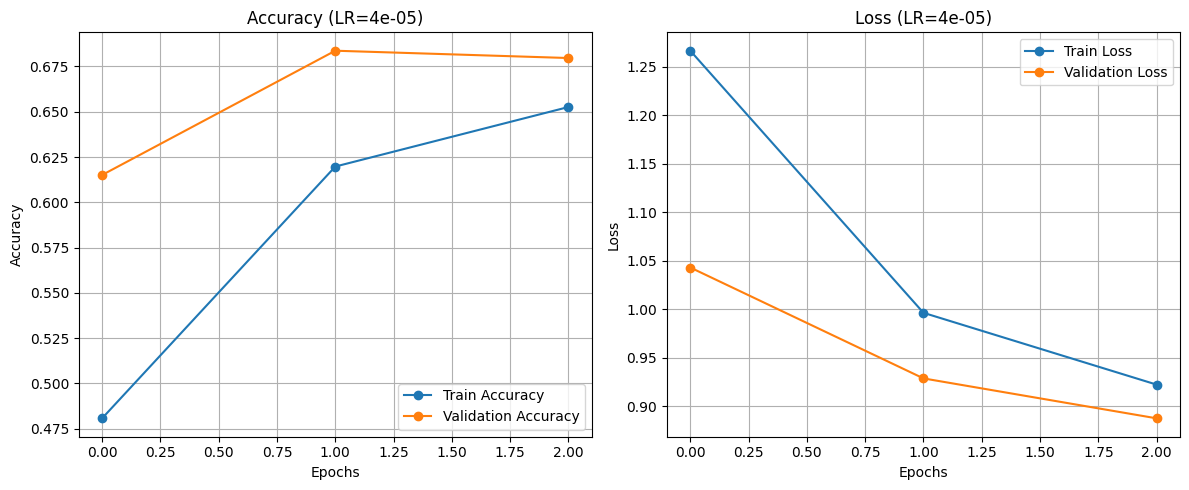

In [13]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy (LR=4e-05)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss (LR=4e-05)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Evaluasi validasi untuk ringkasan
val_loss, val_acc = model_frozen.evaluate(val_dataset, verbose=0)
print(
    f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

# Evaluasi testing
test_loss, test_acc = model_frozen.evaluate(test_dataset, verbose=0)
print(
    f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Validation Loss: 0.8873 | Validation Accuracy: 0.6797
Test Loss: 0.9578 | Test Accuracy: 0.6406


In [18]:
# Evaluasi
pred_logits = model_frozen.predict(test_dataset)
pred_labels = np.argmax(pred_logits, axis=1)
true_labels = np.array(test_labels)
label_names = le.classes_.tolist()

print("\nClassification Report IndoBERT without Fine Tuning:")
print(classification_report(
    true_labels, 
    pred_labels,
    target_names=label_names, 
    digits=4))

93/93 [==============================] - 4s 47ms/step

Classification Report IndoBERT without Fine Tuning:
              precision    recall  f1-score   support

       Cinta     0.5677    0.7788    0.6567       113
     Gembira     0.7344    0.7500    0.7421       188
       Marah     0.8481    0.4268    0.5678       157
       Sedih     0.6336    0.5570    0.5929       149
       Takut     0.5215    0.7132    0.6025       136

    accuracy                         0.6406       743
   macro avg     0.6611    0.6452    0.6324       743
weighted avg     0.6739    0.6406    0.6368       743



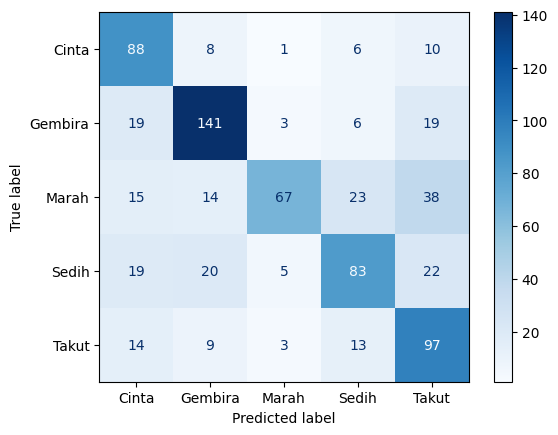

In [17]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)